In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import datetime, os
import random

import os
from tqdm import tqdm
import cv2
import seaborn as sn
import pandas as pd

In [2]:
labels = ['Human', 'Blank','Elephant_African', 'Hog_Red_River','Buffalo_African','Leopard_African','Monkey','Duiker_Blue','Duiker_Red','Porcupine_Brush_Tailed','Rodent','Squirrel','Rat_Giant','Guineafowl_Crested','Duiker_Yellow_Backed','Guineafowl_Black','Mongoose','Rail_Nkulengu','Mammal_Other','Chimpanzee','Bird','Genet','Gorilla','Pangolin','Mongoose_Black_Footed','Mandrillus','Civet_African_Palm','Chevrotain_Water','Cat_Golden']

In [3]:
label_count = {'Human': 34999, 'Blank': 35000, 'Elephant_African': 34999, 'Hog_Red_River': 26069, 'Buffalo_African': 6459, 'Leopard_African': 2142, 'Monkey': 5038, 'Duiker_Blue': 35000, 'Duiker_Red': 34999, 'Porcupine_Brush_Tailed': 13694, 'Rodent': 1358, 'Squirrel': 11348, 'Rat_Giant': 34225, 'Guineafowl_Crested': 1513, 'Duiker_Yellow_Backed': 15436, 'Guineafowl_Black': 12054, 'Mongoose': 5518, 'Rail_Nkulengu': 3269, 'Chimpanzee': 5260, 'Bird': 6649, 'Genet': 3303, 'Gorilla': 1074, 'Pangolin': 872, 'Mongoose_Black_Footed': 1475, 'Mandrillus': 9305, 'Civet_African_Palm': 936, 'Chevrotain_Water': 4713, 'Cat_Golden': 406}

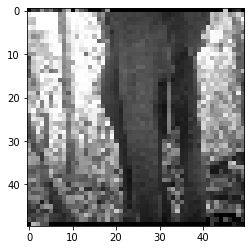

In [4]:
data = np.load("../Data/Data_Gabon/training_data_gabon.npy", allow_pickle=True)
plt.imshow(data[2][0], cmap="gray")
plt.show()

In [5]:
# change duiker_blue and red to duiker
for picture in data:
    if picture[1] == 8:
        picture[1] = 7

In [6]:
other_animal_label = []
new_data = []
counter = {}
for picture in data:
    if label_count[labels[picture[1]]] < 5000:
        if picture[1] not in other_animal_label:
            other_animal_label.append(picture[1])
    else:
        if picture[1] in counter.keys():
            new_data.append(picture)
            counter[picture[1]] += 1
        else:
            new_data.append(picture)
            counter[picture[1]] = 1

In [7]:
# relabel data
new_labels = []
for key in counter.keys():
    new_labels.append(labels[key])                     
    
for item in new_data:
    item[1] = new_labels.index(labels[item[1]])

print(new_labels)

['Mongoose', 'Chimpanzee', 'Elephant_African', 'Duiker_Blue', 'Hog_Red_River', 'Rat_Giant', 'Blank', 'Duiker_Yellow_Backed', 'Human', 'Guineafowl_Black', 'Porcupine_Brush_Tailed', 'Mandrillus', 'Squirrel', 'Bird', 'Monkey', 'Buffalo_African']


In [8]:
counter = {}
for key in other_animal_label:
    counter[key] = 0      

amount_of_pictures = 10000 // len(other_animal_label)
    
# append other animals
for picture in data:
    if picture[1] in other_animal_label:
        if counter[picture[1]] < amount_of_pictures:
            counter[picture[1]] += 1
            picture[1] = len(new_labels)
            new_data.append(picture)

new_labels.append("Other_animal")        
print(new_labels)

['Mongoose', 'Chimpanzee', 'Elephant_African', 'Duiker_Blue', 'Hog_Red_River', 'Rat_Giant', 'Blank', 'Duiker_Yellow_Backed', 'Human', 'Guineafowl_Black', 'Porcupine_Brush_Tailed', 'Mandrillus', 'Squirrel', 'Bird', 'Monkey', 'Buffalo_African', 'Other_animal']


In [9]:
# random shuffle list. 
random.shuffle(new_data)

In [10]:
def create_set(new_data, amount):
    data = []
    second_count = {}
    count = 0
    for item in new_data:
        if item[1] in second_count.keys():
            if second_count[item[1]] >= amount:
                pass
            else:
                data.append(new_data.pop(count))
                second_count[item[1]] += 1
        else:
            data.append(new_data.pop(count))
            second_count[item[1]] = 1
        count += 1
        
    # Normalize pixel values to be between 0 and 1
    for pictures in data:
        pictures[0] = pictures[0] / 255

    return data

val_data = create_set(new_data, 2000)
test_data = create_set(new_data, 2000)

In [11]:
new_count = {}
for picture in new_data:
    if picture[1] in new_count.keys():
        new_count[picture[1]] += 1
    else:
        new_count[picture[1]] = 1
print(new_count)

{3: 65999, 4: 22069, 7: 11436, 8: 30999, 9: 8054, 13: 1901, 5: 29379, 11: 5305, 0: 1518, 2: 30999, 12: 7348, 6: 31000, 1: 1260, 10: 8878, 14: 1038, 16: 7869, 15: 2459}


In [12]:
# creates a data generator object that transforms images
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
# create empty dict and add data augmentation
count_train = {}
for key in new_count.keys():
    count_train[key] = 0

train_data = []
for picture in tqdm(new_data):
    if new_count[picture[1]] >= 10000:
        if count_train[picture[1]] < 10000:
            train_data.append(picture)
            count_train[picture[1]] += 1
    else:
        if count_train[picture[1]] < 10000:
            train_data.append(picture)
            count_train[picture[1]] += 1
            
            img = image.img_to_array(picture[0])  # convert image to numpy arry
            img = img.reshape((1,) + img.shape)  # reshape image

            amount_of_augmentations = 10000 // new_count[picture[1]]
            i = 0
            for batch in datagen.flow(img):
                augment_image = tf.reshape(batch[0], picture[0].shape)
                train_data.append([augment_image, picture[1]])
                count_train[picture[1]] += 1
                i += 1
                if i >= amount_of_augmentations: 
                    break
print(count_train)        
        

100%|██████████| 267511/267511 [00:31<00:00, 8531.79it/s] 

{3: 10000, 4: 10000, 7: 10000, 8: 10000, 9: 10000, 13: 10002, 5: 10000, 11: 10000, 0: 10003, 2: 10000, 12: 10000, 6: 10000, 1: 10000, 10: 10000, 14: 10000, 16: 10000, 15: 10000}


In [14]:
# Normalize pixel values to be between 0 and 1
for pictures in train_data:
    pictures[0] = pictures[0] / 255

# train model

In [15]:
# get the labels
def get_labels(data):
    images, labels = [], []
    for items in data:
        images.append(items[0])
        labels.append(items[1])
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

X_train, y_train = get_labels(train_data)
X_val, y_val = get_labels(val_data)
X_test, y_test = get_labels(test_data)

In [16]:
print(len(new_labels))

17


In [17]:
# reduce dimentions
X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)
X_val = tf.expand_dims(X_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)
y_val = tf.expand_dims(y_test, axis=-1)

In [38]:
# creating the model
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=X_train.shape[1:], padding='same'))
model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Flatten())
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(new_labels), activation='softmax')) # <---- change ending layers!!!

model.summary()  # summary

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 50, 50, 16)        160       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 50, 50, 16)        6416      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 25, 25, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 25, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 12, 12, 32)       

In [39]:
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# With tensorboard
history = model.fit(X_train, y_train, epochs=8, batch_size = 32,
                    validation_data=(X_val, y_val))

# With tensorboard
# history = model.fit(X_train, y_train, epochs=10, batch_size = 32,
#                     validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

Epoch 1/8
5313/5313 [==============================] - 559s 105ms/step - loss: 2.5928 - accuracy: 0.3342 - val_loss: 2.6362 - val_accuracy: 0.2924
Epoch 2/8
5313/5313 [==============================] - 556s 105ms/step - loss: 2.5308 - accuracy: 0.3976 - val_loss: 2.6285 - val_accuracy: 0.3000
Epoch 3/8
5313/5313 [==============================] - 551s 104ms/step - loss: 2.4884 - accuracy: 0.4401 - val_loss: 2.5290 - val_accuracy: 0.3989
Epoch 4/8
5313/5313 [==============================] - 583s 110ms/step - loss: 2.4670 - accuracy: 0.4611 - val_loss: 2.5193 - val_accuracy: 0.4092
Epoch 5/8
5313/5313 [==============================] - 557s 105ms/step - loss: 2.4552 - accuracy: 0.4734 - val_loss: 2.5043 - val_accuracy: 0.4241
Epoch 6/8
5313/5313 [==============================] - 555s 104ms/step - loss: 2.4449 - accuracy: 0.4837 - val_loss: 2.5064 - val_accuracy: 0.4219
Epoch 7/8
5313/5313 [==============================] - 554s 104ms/step - loss: 2.4356 - accuracy: 0.4931 - val_loss: 2

In [40]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(test_acc)

1063/1063 [==============================] - 12s 12ms/step - loss: 2.4769 - accuracy: 0.4517
0.4517352879047394


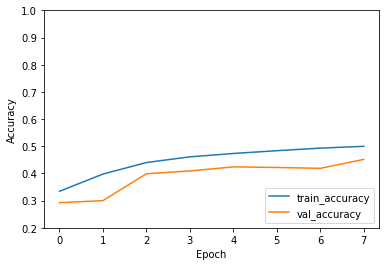

In [41]:
# plot results
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

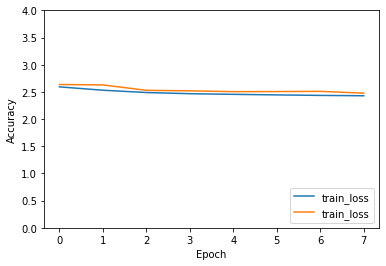

In [42]:
# plot results
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 4])
plt.legend(loc='lower right')

In [43]:
# score per class
Y_test = tf.reshape(y_test, [len(y_test)])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes()
y_pred = np.argmax(model.predict(X_test), axis=-1)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2000
           1       0.83      0.39      0.53      2000
           2       0.50      0.46      0.48      2000
           3       0.20      0.54      0.29      2000
           4       0.00      0.00      0.00      2000
           5       0.36      0.92      0.52      2000
           6       0.52      0.85      0.65      2000
           7       0.60      0.80      0.68      2000
           8       0.58      0.68      0.63      2000
           9       0.66      0.63      0.65      2000
          10       0.25      0.12      0.16      2000
          11       0.45      0.75      0.56      2000
          12       0.28      0.51      0.37      2000
          13       0.56      0.03      0.05      2000
          14       0.57      0.14      0.23      2000
          15       0.84      0.55      0.66      2000
          16       0.94      0.30      0.45      2000

    accuracy              

C:\Users\Siebren\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-44-27b0bf942474>:6: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized


<AxesSubplot:>

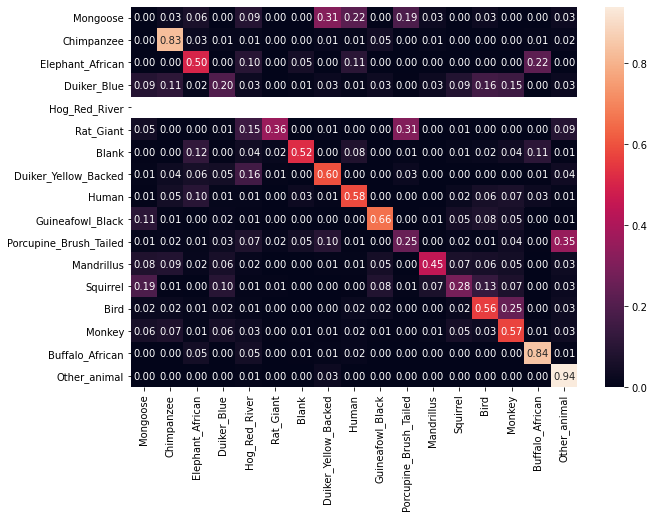

In [44]:
y_pred = model.predict(X_test)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for y in y_test], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized

df_cm = pd.DataFrame(cmn, index = [i for i in new_labels],
                  columns = [i for i in new_labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [25]:
# model.save('Models/model_V3.h5')

In [26]:
# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('Models/model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [27]:
# clears session
# keras.backend.clear_session()

# Test on myanmar data

0


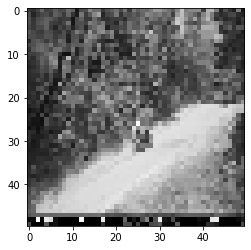

In [93]:
myanmar_data = np.load("../Data/Data_Myanmar/testing_data_myanmar_for_gabon_model.npy", allow_pickle=True)
i = 2927
plt.imshow(myanmar_data[i][0], cmap="gray")
print(myanmar_data[i][1])
plt.show()

In [94]:
print(new_labels)

['Mongoose', 'Chimpanzee', 'Elephant_African', 'Duiker_Blue', 'Hog_Red_River', 'Rat_Giant', 'Blank', 'Duiker_Yellow_Backed', 'Human', 'Guineafowl_Black', 'Porcupine_Brush_Tailed', 'Mandrillus', 'Squirrel', 'Bird', 'Monkey', 'Buffalo_African', 'Other_animal']


In [95]:
myan_original_labels = ["Cow", "Cow_cart", "Elephant_canopy_level", "Elephant_ground_level", "Poachers", "Truck", "Villagers", "Three_weel_cart"]

# change labels
for data in myanmar_data:
    if data[1] == 0:
        data[1] = new_labels.index("Human")
    elif data[1] == 1:
        data[1] = new_labels.index("Other_animal")
    elif data[1] == 2:
        data[1] = new_labels.index("Elephant_African")

print(f"Human label: " + str(new_labels.index("Human")))
print(f"Other label: " + str(new_labels.index("Other_animal")))
print(f"Elephant label: " + str(new_labels.index("Elephant_African")))

Human label: 8
Other label: 16
Elephant label: 2


In [96]:
pictures_myan = []
labels_myan = []

# Normalize pixel values to be between 0 and 1
for pic in myanmar_data:
    pic[0] = pic[0] / 255

for picture_myan, label_myan in myanmar_data:
    pictures_myan.append(picture_myan)
    labels_myan.append(label_myan)

In [97]:
pictures_myan = np.array(pictures_myan)
labels_myan = np.array(labels_myan)

pictures_myan = tf.expand_dims(pictures_myan, axis=-1)
labels_myan = tf.expand_dims(labels_myan, axis=-1)

In [98]:
test_loss, test_acc = model.evaluate(pictures_myan, labels_myan, verbose=1)
print(test_acc)

92/92 [==============================] - 1s 6ms/step - loss: 2.4009 - accuracy: 0.0987
0.09870218485593796


In [100]:
# score per class
Y_test = tf.reshape(labels_myan, [2928])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(pictures_myan)
# np.argmax(model.predict(pictures_myan), axis=-1)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.02      0.24      0.04        92
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.73      0.10      0.18      2562
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00       274

    accuracy              

In [101]:
predictions = model.predict_on_batch(pictures_myan)

In [81]:
correct_zero, correct_one, correct_two = 0, 0, 0
for i in range(len(predictions)):
    if Y_test[i].numpy() != predictions[i].argmax():
        print("correct: " + str(Y_test[i].numpy()) + " pred: " + str(predictions[i].argmax()))
        print("---------------------")
    else:
        if Y_test[i].numpy() == 0:
            correct_zero += 1
        elif Y_test[i].numpy() == 1:
            correct_one += 1
        elif Y_test[i].numpy() == 2:
            correct_two += 1

correct: 8 pred: 1
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 2 pred: 11
---------------------
correct: 16 pred: 8
---------------------
correct: 8 pred: 9
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 16 pred: 14
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 16 pred: 1
---------------------
correct: 8 pred: 4
---------------------
correct: 16 pred: 15
---------------------
correct: 8 pred: 6
---------------------
correct: 16 pred: 15
---------------------
correct: 16 pred: 1
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correc

correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 16 pred: 8
---------------------
correct: 8 pred: 11
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 2 pred: 10
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 16 pred: 8
---------------------
correct: 16 pred: 15
---------------------
correct: 16 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 16 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct:

correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 16 pred: 2
---------------------
correct: 16 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 2 pred: 10
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 15
---------------------
correct: 8 pred: 2
---------------------
correct: 16 pred: 8
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 14
---------------------
correct: 2 pred: 6
---------------------
correct: 8

correct: 8 pred: 6
---------------------
correct: 8 pred: 3
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 16 pred: 10
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 16 pred: 2
---------------------
correct: 8 pred: 4
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 16 pred: 2
---------------------
correct: 2 pred: 10
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 12
---------------------
correct: 8 pred: 6
---------------------
correct: 8

correct: 8 pred: 2
---------------------
correct: 16 pred: 15
---------------------
correct: 16 pred: 8
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 3
---------------------
correct: 16 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 16 pred: 3
---------------------
correct: 2 pred: 8
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 2 pred: 10
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 14
---------------------
correct: 8 pred: 6
---------------------
correct: 

correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 16 pred: 8
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 1
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 11
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 6
---------------------
correct: 8 pred: 2
---------------------
correct: 8 pred: 2
---------------------
correct: 16 pred: 8
---------------------
correct: 8 pr

In [102]:
count_zero, count_one, count_two = 0, 0, 0
for label in labels_myan:
    if label == 0:
        count_zero += 1
    elif label == 1:
        count_one += 1
    elif label == 2:
        count_two += 1
print("zero " + str(count_zero) + " / " + str(correct_zero))
print("one " + str(count_one) + " / " + str(correct_one))
print("two " + str(count_two) + " / " + str(correct_two))

zero 0 / 0
one 0 / 0
two 92 / 22


<AxesSubplot:>

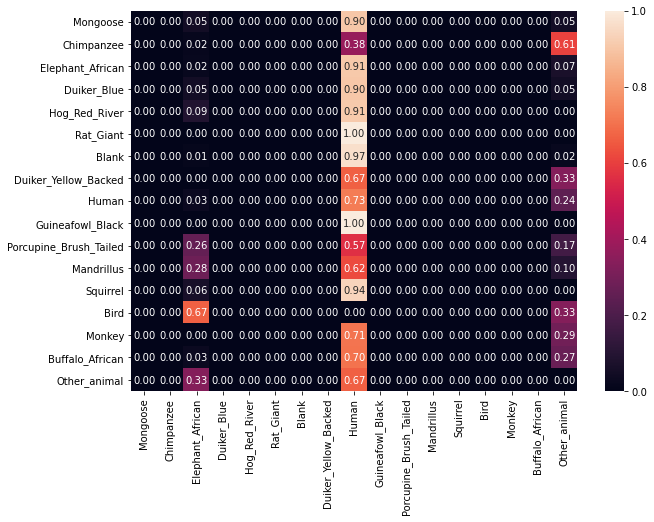

In [104]:
y_pred = model.predict(pictures_myan)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for y in labels_myan], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized

df_cm = pd.DataFrame(cmn, index = [i for i in new_labels],
                  columns = [i for i in new_labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f')